# Create media designs using ART

We use ART to provide suggested designs for media components for which to get phenotypic data.  We will use absorbance at 340nm as assay for this experiment.

For DBTL 3 we create 10 designs from an exploratory mode with $\alpha=1.$ and relative recommendations distance 200%, 5 designs from the exploitation mode ($\alpha=0$) and relative recommendations distance 200%, and 1 design being close to the standard media as a control, totalling 16 designs in triplicates.


Tested using **ART Prod** kernel on skynet.ese.lbl.gov

## Inputs and output

**Required file to run this notebook:**
- `Putida_media_bounds_extended.csv`
- `standard_recipe_concentrations_extended.csv`
- EDD study slug(s)

**File generated by running this notebook**
- 
-
-

The files are stored in the user defined directory. 

## Setup

Clone the git repository with the `ART` library 

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
<!-- <font color='red'> _____ -->
<!-- **WE SHOULD TALK ABOUT LICENSING HERE!!!** </font> -->

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.

Importing needed libraries:

In [1]:
import os
import sys
import re
import warnings
import pickle
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import scipy



Import ART

In [2]:
sys.path.append('../')        # Make sure this is the location for the ART library 
sys.path.append('../media_compiler')

from art.core import RecommendationEngine 
import art.plot as plot
import art.utility as utils
import edd_utils as eddu
from core import designs_pairwise
import warning_utils
warning_utils.filter_end_user_warnings()



/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## User parameters

In [3]:
CYCLE = '3'

user_params = {
    'bounds_file': f'../flaviolin yield data/Putida_media_bounds_yield.csv',
    'output_dir': f'../flaviolin yield data/DBTL{CYCLE}', # Folder for output files,
    'standard_media_file': '../flaviolin yield data/standard_recipe_concentrations.csv', #location of the standard media recipe
    'study_slug_1': 'combinatorial-media-optimization-for-flavioli-8a70', #DBTL1
    'study_slug_2': 'combinatorial-media-optimization-for-flaviolin-yie',#DBTL2
    'edd_server': 'edd.jbei.org',
    'username': 'azournas',
}

In [4]:
os.makedirs(user_params['output_dir'], exist_ok=True) #make the directory to store the output files

### Defining media components and the number of instances (designs) to be created

Specify which components to explore:

In [5]:
user_params['components'] = [
    'H3BO3[mM]',
    'Glucose[mM]',
    'K2SO4[mM]',
    'K2HPO4[mM]',
    'FeSO4[mM]',
    'NH4Cl[mM]',
    'MgCl2[mM]',
    'NaCl[mM]',
    '(NH4)6Mo7O24[mM]',
    'CoCl2[mM]',
    'CuSO4[mM]',
    'MnSO4[mM]',
    'ZnSO4[mM]',
    # 'CaCl2[mM]'    
]

user_params['response'] = 'OD340_yield' #this will be the parameter we will maximize

Here we specify how many instances (designs) we want to create and how many replicates:

In [6]:
user_params['n_instances_explor'] = 10 # number of exploration recommendations
user_params['n_instances_exploit'] = 5 # number of exploitation recommendations
user_params['n_replicates'] = 3 # number of replicates generated in the biolector plate.
user_params['seed'] = 42
#The biolector plate we are using here is a 48-well plate. For 3 replicates, the total number of conditions tested will need to be 48/3 = 16. In this case 13 exploitation, 2 exploration and 1 standard. 

Lastly we specify the exploration and exploitation parameters (alpha) and the number of iterations that Parallel tempering will go through

In [7]:
user_params['alpha_explor'] = 1
user_params['alpha_exploit'] = 0 
user_params['n_iter'] = 1e5
user_params['distance_type'] = 'all'

In [8]:
user_params['scale_input_vars'] = False
user_params['cross_val'] = True
user_params['recommend'] = False
user_params['cross_val_partitions'] = 10



## Load the data

In [9]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")

In [10]:
study_slug_1 = user_params['study_slug_1']
study_slug_2 = user_params['study_slug_2']


edd_server = user_params['edd_server']
username = user_params['username']

In [11]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
    load_from_disk = True
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')    
    load_from_disk = False

OK! Connection to EDD successful. We will try to load data from EDD...


In [12]:
try:
    df_1 = eddu.export_study(session, study_slug_1, edd_server=edd_server)
    df_2 = eddu.export_study(session, study_slug_2, edd_server=edd_server)
    load_from_disk = False
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')
    load_from_disk = True

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [13]:

if load_from_disk:
    df_1 = pd.read_csv('../flaviolin data/df_dbtl1-repeat.csv')
    df_2 = pd.read_csv('../flaviolin data/df_dbtl2-repeat.csv')
else:
    df_1.to_csv('../flaviolin data/df_dbtl1-repeat.csv')
    df_2.to_csv('../flaviolin data/df_dbtl2-repeat.csv')



In [14]:
df_1.head()

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,208439,Combinatorial Media Optimization for Flaviolin...,208440,c7f6759c-abae-42f1-94e2-da344bdb1678,C1_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208488,C1_WA1_C1-R1,NaN,OD340,0,NaN,0.1664,48.0
1,208439,Combinatorial Media Optimization for Flaviolin...,208441,5c50572c-baaa-4537-91f9-d0c19304dd71,C1_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208489,C1_WA1_C1-R2,NaN,OD340,0,NaN,0.1707,48.0
2,208439,Combinatorial Media Optimization for Flaviolin...,208442,8e320b95-6038-4ce6-baee-df5506e1eda5,C1_WA1_C1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208490,C1_WA1_C1-R3,NaN,OD340,0,NaN,0.1535,48.0
3,208439,Combinatorial Media Optimization for Flaviolin...,208443,dea4c0a6-77ec-4937-8541-289e4d2a534a,C1_WD1_F1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208491,C1_WD1_F1-R1,NaN,OD340,0,NaN,0.1894,48.0
4,208439,Combinatorial Media Optimization for Flaviolin...,208444,d08877ac-7bf2-4152-adb0-a378d9fdb36a,C1_WD1_F1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208492,C1_WD1_F1-R2,NaN,OD340,0,NaN,0.1954,48.0


In [15]:
df_2.head()

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,208342,Combinatorial Media Optimization for Flaviolin...,208343,2333e82e-d052-4bc2-9ba3-dc478ab73cf8,C2_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208391,C2_WA1_C1-R1,NaN,OD340,0,NaN,0.5700,48.0
1,208342,Combinatorial Media Optimization for Flaviolin...,208344,27133779-15eb-4f9a-8774-578f89c28191,C2_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208392,C2_WA1_C1-R2,NaN,OD340,0,NaN,0.4714,48.0
2,208342,Combinatorial Media Optimization for Flaviolin...,208345,0ec14aee-e5cb-46a4-a6ff-b21369acde8f,C2_WA1_C1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208393,C2_WA1_C1-R3,NaN,OD340,0,NaN,0.4779,48.0
3,208342,Combinatorial Media Optimization for Flaviolin...,208346,89e380d5-3b40-4840-8e61-2d2f2dd5a268,C2_WD1_F1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208394,C2_WD1_F1-R1,NaN,OD340,0,NaN,0.4441,48.0
4,208342,Combinatorial Media Optimization for Flaviolin...,208347,01df708b-6438-43a6-9607-daec711598b2,C2_WD1_F1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208395,C2_WD1_F1-R2,NaN,OD340,0,NaN,0.4453,48.0


## Preprocess the data

Concatenate the six studies:

In [16]:
df = pd.concat([df_1, df_2])

In [17]:
# df_control_vals = df[['Line Name','Control_Val']]

In [18]:
df.head()

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,208439,Combinatorial Media Optimization for Flaviolin...,208440,c7f6759c-abae-42f1-94e2-da344bdb1678,C1_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208488,C1_WA1_C1-R1,NaN,OD340,0,NaN,0.1664,48.0
1,208439,Combinatorial Media Optimization for Flaviolin...,208441,5c50572c-baaa-4537-91f9-d0c19304dd71,C1_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208489,C1_WA1_C1-R2,NaN,OD340,0,NaN,0.1707,48.0
2,208439,Combinatorial Media Optimization for Flaviolin...,208442,8e320b95-6038-4ce6-baee-df5506e1eda5,C1_WA1_C1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208490,C1_WA1_C1-R3,NaN,OD340,0,NaN,0.1535,48.0
3,208439,Combinatorial Media Optimization for Flaviolin...,208443,dea4c0a6-77ec-4937-8541-289e4d2a534a,C1_WD1_F1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208491,C1_WD1_F1-R1,NaN,OD340,0,NaN,0.1894,48.0
4,208439,Combinatorial Media Optimization for Flaviolin...,208444,d08877ac-7bf2-4152-adb0-a378d9fdb36a,C1_WD1_F1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208492,C1_WD1_F1-R2,NaN,OD340,0,NaN,0.1954,48.0


In [19]:
df.tail()

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
43,208342,Combinatorial Media Optimization for Flaviolin...,208386,59c38be5-3c17-420f-9e8f-b2f642263bc0,C2_WA8_C8-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208434,C2_WA8_C8-R2,NaN,OD340,0,NaN,0.0657,48.0
44,208342,Combinatorial Media Optimization for Flaviolin...,208387,3c61b253-0f42-40ae-9824-e936dc95652b,C2_WA8_C8-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208435,C2_WA8_C8-R3,NaN,OD340,0,NaN,0.0616,48.0
45,208342,Combinatorial Media Optimization for Flaviolin...,208388,0d66ccf4-0113-41f4-b825-9a78acfb6f82,C2_WD8_F8-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208436,C2_WD8_F8-R1,NaN,OD340,0,NaN,0.2575,48.0
46,208342,Combinatorial Media Optimization for Flaviolin...,208389,8f9c49de-137f-448d-ac84-ccf89c568480,C2_WD8_F8-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208437,C2_WD8_F8-R2,NaN,OD340,0,NaN,0.2234,48.0
47,208342,Combinatorial Media Optimization for Flaviolin...,208390,1cdea42a-a962-4cd0-bdc4-bb766ddd50f8,C2_WD8_F8-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,208438,C2_WD8_F8-R3,NaN,OD340,0,NaN,0.2387,48.0


In [20]:
df['Study Name'].unique()

array(['Combinatorial Media Optimization for Flaviolin Yield DBTL1',
       'Combinatorial Media Optimization for Flaviolin Yield DBTL2'],
      dtype=object)

Drop unnecessary columns:

In [21]:
df = df.loc[:,['Line Name', 'Value','Measurement Type','Line Description']]


Pivot the dataframe: This will generate a line for each sample with the corresponding OD600 and OD340 values

In [22]:
df = df.pivot(index=["Line Name", "Line Description"], columns="Measurement Type", values="Value")#, 'Control_Val'])
df.reset_index(inplace=True)


In [23]:
df.head()

Measurement Type,Line Name,Line Description,OD340
0,C1_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.1664
1,C1_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.1707
2,C1_WA1_C1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.1535
3,C1_WA2_C2-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.3910
4,C1_WA2_C2-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.4007


Drop OD600 since we are not using it

### Adding media information to the data frame

Add columns for each component:

In [24]:
components = re.split(': |, ', df['Line Description'][0])[::2]
for comp in components:
    df[comp] = None
# df['CaCl2[mM]'] = 0 # add a column for CaCl2. 
#CaCl2 is only added to DBTL 7 and 8 so it doesn't exist in the line descriptions for DBTL 1-6. 
#Concentration of CaCl2 will be 0 for DBTL 1-6

#df['Kan[g/L]'] = None # add a column for Kan. 
#Kan concentration is 0.05 g/l. 
#This is the same concentration for all cases and is not used by ART.
#this is in the Line descriptions only for DBTL8



For every component in the line description assign the right value in each column created previously.

In [25]:
for i in range(len(df)):
    values = re.split(': |, ', df['Line Description'][i])[1::2]
    for c, value in enumerate(values):
        df.iloc[i, (3+c)] = float(value)


df.drop(columns='Line Description', inplace=True)
#df = df.merge(df_control_vals, on='Line Name')
#df['OD340'] = df['OD340']/df['Control_Val']

In [26]:
df

Measurement Type,Line Name,OD340,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],Kan[g/l]
0,C1_WA1_C1-R1,0.1664,40.0,4.0,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.05
1,C1_WA1_C1-R2,0.1707,40.0,4.0,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.05
2,C1_WA1_C1-R3,0.1535,40.0,4.0,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.05
3,C1_WA2_C2-R1,0.3910,40.0,4.0,0.001096,129.69516,0.215986,5.430301,0.070543,9.628863,0.396082,21.94981,0.000185,0.000054,0.000027,0.000771,0.000028,0.05
4,C1_WA2_C2-R2,0.4007,40.0,4.0,0.001096,129.69516,0.215986,5.430301,0.070543,9.628863,0.396082,21.94981,0.000185,0.000054,0.000027,0.000771,0.000028,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,C2_WD7_F7-R2,0.1332,40.0,4.0,0.001576,10.077184,0.036933,6.538513,0.008999,7.031522,0.250629,9.100841,0.000005,0.000068,0.0001,0.0008,0.0001,0.05
92,C2_WD7_F7-R3,0.1453,40.0,4.0,0.001576,10.077184,0.036933,6.538513,0.008999,7.031522,0.250629,9.100841,0.000005,0.000068,0.0001,0.0008,0.0001,0.05
93,C2_WD8_F8-R1,0.2575,40.0,4.0,0.004091,19.348252,0.30044,1.399625,0.009412,9.987207,0.525179,53.652264,0.00003,0.000276,0.0001,0.0008,0.0001,0.05
94,C2_WD8_F8-R2,0.2234,40.0,4.0,0.004091,19.348252,0.30044,1.399625,0.009412,9.987207,0.525179,53.652264,0.00003,0.000276,0.0001,0.0008,0.0001,0.05


### Include Yield and clean up the training data

Include the Yield column:

In [27]:
df['OD340_yield'] = df['OD340']/df['Glucose[mM]']

In [28]:
df.head()

Measurement Type,Line Name,OD340,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],Kan[g/l],OD340_yield
0,C1_WA1_C1-R1,0.1664,40.0,4.0,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.05,0.005044
1,C1_WA1_C1-R2,0.1707,40.0,4.0,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.05,0.005174
2,C1_WA1_C1-R3,0.1535,40.0,4.0,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.05,0.004653
3,C1_WA2_C2-R1,0.3910,40.0,4.0,0.001096,129.69516,0.215986,5.430301,0.070543,9.628863,0.396082,21.94981,0.000185,0.000054,0.000027,0.000771,0.000028,0.05,0.003015
4,C1_WA2_C2-R2,0.4007,40.0,4.0,0.001096,129.69516,0.215986,5.430301,0.070543,9.628863,0.396082,21.94981,0.000185,0.000054,0.000027,0.000771,0.000028,0.05,0.00309


In [29]:
df.tail()

Measurement Type,Line Name,OD340,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],Kan[g/l],OD340_yield
91,C2_WD7_F7-R2,0.1332,40.0,4.0,0.001576,10.077184,0.036933,6.538513,0.008999,7.031522,0.250629,9.100841,0.000005,0.000068,0.0001,0.0008,0.0001,0.05,0.013218
92,C2_WD7_F7-R3,0.1453,40.0,4.0,0.001576,10.077184,0.036933,6.538513,0.008999,7.031522,0.250629,9.100841,0.000005,0.000068,0.0001,0.0008,0.0001,0.05,0.014419
93,C2_WD8_F8-R1,0.2575,40.0,4.0,0.004091,19.348252,0.30044,1.399625,0.009412,9.987207,0.525179,53.652264,0.00003,0.000276,0.0001,0.0008,0.0001,0.05,0.013309
94,C2_WD8_F8-R2,0.2234,40.0,4.0,0.004091,19.348252,0.30044,1.399625,0.009412,9.987207,0.525179,53.652264,0.00003,0.000276,0.0001,0.0008,0.0001,0.05,0.011546
95,C2_WD8_F8-R3,0.2387,40.0,4.0,0.004091,19.348252,0.30044,1.399625,0.009412,9.987207,0.525179,53.652264,0.00003,0.000276,0.0001,0.0008,0.0001,0.05,0.012337


Remove all the low performing strains

bar plot the training data

Define the control lines. In DBTL 1 and 2, controls were wells F5 to F8. In other DBTL cycles the control is stored in the last column (D8, E8, F8).

In [30]:
control_lines = df[df['Line Name'].str.find('_F8') > 0]

#control_lines = control_lines.append(df[df['Line Name'].str.find('WD8_F8') > 0])

control_lines = pd.concat([control_lines, df[df['Line Name'].str.find('F8') > 0]], ignore_index=True)

### Convert the data to EDD format

Pivot the dataframe back to EDD format, including all the components names and protocols:

In [31]:
df_stacked = df.set_index('Line Name').stack().reset_index()
df_stacked.columns = ['Line Name', 'Measurement Type', 'Value']

### OD340 of the highest performing strains is at 0.7. 
### I multiply the data by 1000 to bring it up to ~700 to improve parallel tempering performance
df_stacked.loc[df_stacked["Measurement Type"] == "OD340", 'Value'] = df_stacked.loc[df_stacked["Measurement Type"] == "OD340", 'Value'] 

df_stacked


,Line Name,Measurement Type,Value
0,C1_WA1_C1-R1,OD340,0.1664
1,C1_WA1_C1-R1,MOPS[mM],40.0
2,C1_WA1_C1-R1,Tricine[mM],4.0
3,C1_WA1_C1-R1,H3BO3[mM],0.003661
4,C1_WA1_C1-R1,Glucose[mM],32.989243
...,...,...,...
1723,C2_WD8_F8-R3,CuSO4[mM],0.0001
1724,C2_WD8_F8-R3,MnSO4[mM],0.0008
1725,C2_WD8_F8-R3,ZnSO4[mM],0.0001
1726,C2_WD8_F8-R3,Kan[g/l],0.05


## Define functions we will use to train art, generate recommendations and plot the results

In [34]:
def train_art(df, user_params,art_filename):
    art_params = {
    'input_vars': user_params['components'],
    'response_vars': [user_params['response']],
    'bounds': utils.read_table(user_params['bounds_file']), # file with bounds# input variables, i.e. features
    'scale_input_vars': user_params['scale_input_vars'],
    'cross_val': user_params['cross_val'],
    'recommend': user_params['recommend'],
    'output_dir': user_params['output_dir'],  # directory to store this output
    'verbose': 1,
    'num_tpot_models': 4,
    'max_mcmc_cores': 4,
    'seed': user_params['seed'],
    'build_model' : True,
    'recommend' : False,
    'cross_val_partitions' : user_params['cross_val_partitions']
    }
    
    # art_params['bounds'] = art_params['bounds'].drop(index=[0,1,3])
    
    art = RecommendationEngine(df=df, **art_params)
    
    art.save()
    
    orig_file_name = f"{art_params['output_dir']}/art.cpkl"
    new_file_name = f"{art_params['output_dir']}/{art_filename}"
    os.rename(orig_file_name, new_file_name)

    return art

In [40]:
user_params




{'bounds_file': '../flaviolin yield data/Putida_media_bounds_yield.csv',
 'output_dir': '../flaviolin yield data/DBTL3',
 'standard_media_file': '../flaviolin yield data/standard_recipe_concentrations.csv',
 'study_slug_1': 'combinatorial-media-optimization-for-flavioli-8a70',
 'study_slug_2': 'combinatorial-media-optimization-for-flaviolin-yie',
 'edd_server': 'edd.jbei.org',
 'username': 'azournas',
 'components': ['H3BO3[mM]',
  'Glucose[mM]',
  'K2SO4[mM]',
  'K2HPO4[mM]',
  'FeSO4[mM]',
  'NH4Cl[mM]',
  'MgCl2[mM]',
  'NaCl[mM]',
  '(NH4)6Mo7O24[mM]',
  'CoCl2[mM]',
  'CuSO4[mM]',
  'MnSO4[mM]',
  'ZnSO4[mM]'],
 'response': 'OD340_yield',
 'n_instances_explor': 10,
 'n_instances_exploit': 5,
 'n_replicates': 3,
 'seed': 42,
 'alpha_explor': 1,
 'alpha_exploit': 0,
 'n_iter': 100000.0,
 'distance_type': 'all',
 'scale_input_vars': False,
 'cross_val': True,
 'recommend': False,
 'cross_val_partitions': 10}

### Train ART

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.


ART identified 32 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models (2 parallel splits X (L0:  (2 parallel TPOTS X 1 jobs), L1: 2 jobs))…


/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Fitting L0 models (2 jobs)…
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…


/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not avail

Best pipeline: LassoLarsCV(RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.8500000000000001, min_samples_leaf=1, min_samples_split=9, n_estimators=100), normalize=False)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: AdaBoostRegressor(input_matrix, learning_rate=0.1, loss=square, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: RandomForestRegressor(AdaBoostRegressor(input_matrix, learning_rate=1.0, loss=exponential, n_estimators=100), bootstrap=False, max_features=0.6000000000000001, min_samples_leaf=9, min_samples_split=8, n_estimators=100)
Best pipeline: XGBRegressor(ElasticNetCV(input_matrix, l1_ratio=0.7000000000000001, tol=0.1), learning_rate=0.1, max_depth=9, min_child_weight=9, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.9500000000000001, verbosity=0)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: XGBRegressor(FeatureAgglomeration(input_matrix, affinity=manhattan, linkage=average), learning_rate=0.1, max_depth=2, min_child_weight=5, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.6000000000000001, verbosity=0)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: XGBRegressor(input_matrix, learning_rate=0.1, max_depth=6, min_child_weight=15, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=1.0, verbosity=0)
Best pipeline: AdaBoostRegressor(SelectFwe(PCA(input_matrix, iterated_power=9, svd_solver=randomized), alpha=0.018000000000000002), learning_rate=0.5, loss=linear, n_estimators=100)
Done fitting L0 models in 86.00 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 28.74 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: KNeighborsRegressor(PCA(Normalizer(input_matrix, norm=l1), iterated_power=6, svd_solver=randomized), n_neighbors=3, p=1, weights=distance)
Done fitting L0 models in 119.25 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 21.75 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: LassoLarsCV(MaxAbsScaler(RandomForestRegressor(input_matrix, bootstrap=False, max_features=0.6000000000000001, min_samples_leaf=10, min_samples_split=4, n_estimators=100)), normalize=False)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: KNeighborsRegressor(RobustScaler(RBFSampler(RBFSampler(Normalizer(input_matrix, norm=l2), gamma=0.45), gamma=0.45)), n_neighbors=4, p=2, weights=distance)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: XGBRegressor(VarianceThreshold(FeatureAgglomeration(input_matrix, affinity=l2, linkage=average), threshold=0.001), learning_rate=0.1, max_depth=6, min_child_weight=4, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.9000000000000001, verbosity=0)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: AdaBoostRegressor(Nystroem(input_matrix, gamma=0.6000000000000001, kernel=linear, n_components=3), learning_rate=0.001, loss=linear, n_estimators=100)
Best pipeline: XGBRegressor(PCA(PCA(LassoLarsCV(input_matrix, normalize=True), iterated_power=8, svd_solver=randomized), iterated_power=8, svd_solver=randomized), learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.7500000000000001, verbosity=0)


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Done fitting L0 models in 78.98 s
Best pipeline: XGBRegressor(OneHotEncoder(input_matrix, minimum_fraction=0.25, sparse=False, threshold=10), learning_rate=0.5, max_depth=2, min_child_weight=9, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.9000000000000001, verbosity=0)


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the p

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Best pipeline: LassoLarsCV(ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=0.8500000000000001, min_samples_leaf=5, min_samples_split=4, n_estimators=100), normalize=True)


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 36 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Done building ensemble model in 37.25 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…
Best pipeline: AdaBoostRegressor(input_matrix, learning_rate=1.0, loss=linear, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: RandomForestRegressor(ElasticNetCV(FeatureAgglomeration(input_matrix, affinity=l1, linkage=complete), l1_ratio=0.9500000000000001, tol=0.1), bootstrap=True, max_features=0.2, min_samples_leaf=2, min_samples_split=4, n_estimators=100)


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Done fitting L0 models in 141.22 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the p

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Best pipeline: LassoLarsCV(XGBRegressor(input_matrix, learning_rate=0.1, max_depth=2, min_child_weight=20, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.7000000000000001, verbosity=0), normalize=False)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: AdaBoostRegressor(PCA(input_matrix, iterated_power=3, svd_solver=randomized), learning_rate=0.5, loss=exponential, n_estimators=100)


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Done building ensemble model in 29.61 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…
Best pipeline: AdaBoostRegressor(FeatureAgglomeration(input_matrix, affinity=manhattan, linkage=complete), learning_rate=0.01, loss=square, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: AdaBoostRegressor(ExtraTreesRegressor(MaxAbsScaler(PCA(input_matrix, iterated_power=6, svd_solver=randomized)), bootstrap=False, max_features=0.9500000000000001, min_samples_leaf=13, min_samples_split=4, n_estimators=100), learning_rate=0.5, loss=square, n_estimators=100)
Done fitting L0 models in 87.74 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Done building ensemble model in 24.35 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…
Best pipeline: AdaBoostRegressor(PCA(input_matrix, iterated_power=4, svd_solver=randomized), learning_rate=1.0, loss=square, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: ElasticNetCV(OneHotEncoder(Nystroem(PolynomialFeatures(Normalizer(input_matrix, norm=l1), degree=2, include_bias=False, interaction_only=False), gamma=0.05, kernel=additive_chi2, n_components=8), minimum_fraction=0.05, sparse=False, threshold=10), l1_ratio=0.9, tol=1e-05)
Best pipeline: AdaBoostRegressor(XGBRegressor(SGDRegressor(LassoLarsCV(input_matrix, normalize=False), alpha=0.001, eta0=0.01, fit_intercept=True, l1_ratio=0.75, learning_rate=constant, loss=epsilon_insensitive, penalty=elasticnet, power_t=1.0), learning_rate=0.1, max_depth=10, min_child_weight=9, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.3, verbosity=0), learning_rate=1.0, loss=exponential, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: AdaBoostRegressor(PCA(input_matrix, iterated_power=8, svd_solver=randomized), learning_rate=1.0, loss=square, n_estimators=100)


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.643654314048478e-07, tolerance: 4.889102501115192e-08
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.2269584176954367e-07, tolerance: 4.889102501115192e-08
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.5880404338097605e-07, tolerance: 4.889102501115192e-08
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/art/.venv/lib/python3.11/site-packag

Done fitting L0 models in 133.44 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.970459580673405e-08, tolerance: 4.4023525362535344e-08
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.5852041120599445e-08, tolerance: 4.4023525362535344e-08
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.049474132589251e-08, tolerance: 4.4023525362535344e-08
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/art/.venv/lib/python3.11/site-pack

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Best pipeline: DecisionTreeRegressor(PCA(input_matrix, iterated_power=5, svd_solver=randomized), max_depth=7, min_samples_leaf=6, min_samples_split=10)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 31 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Done building ensemble model in 32.44 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…
Best pipeline: XGBRegressor(StandardScaler(RidgeCV(input_matrix)), learning_rate=0.1, max_depth=3, min_child_weight=4, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.55, verbosity=0)
Best pipeline: ExtraTreesRegressor(RidgeCV(input_matrix), bootstrap=False, max_features=0.9000000000000001, min_samples_leaf=5, min_samples_split=9, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: DecisionTreeRegressor(AdaBoostRegressor(input_matrix, learning_rate=1.0, loss=exponential, n_estimators=100), max_depth=6, min_samples_leaf=7, min_samples_split=9)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: AdaBoostRegressor(XGBRegressor(input_matrix, learning_rate=0.001, max_depth=4, min_child_weight=15, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.8500000000000001, verbosity=0), learning_rate=0.1, loss=linear, n_estimators=100)
Best pipeline: AdaBoostRegressor(ExtraTreesRegressor(RidgeCV(ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=0.7500000000000001, min_samples_leaf=10, min_samples_split=16, n_estimators=100)), bootstrap=True, max_features=0.7500000000000001, min_samples_leaf=10, min_samples_split=16, n_estimators=100), learning_rate=0.001, loss=square, n_estimators=100)
Done fitting L0 models in 212.25 s
Best pipeline: AdaBoostRegressor(LinearSVR(XGBRegressor(input_matrix, learning_rate=0.5, max_depth=8, min_child_weight=4, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.15000000000000002, verbosity=0), C=15.0, dual=True, epsilon=1.0, loss=squared_epsilon_insensitive, tol=0.1), learning_rate=1.0, loss=exponen

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Building ensemble model (2 sampling jobs)…% [645/22000 00:01<00:47 Sampling 2 chains, 0 divergences]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 22 seconds.


Done building ensemble model in 23.30 s9% [17774/22000 00:24<00:05 Sampling 2 chains, 2 divergences]
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…


We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 31 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Done building ensemble model in 32.19 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…
Best pipeline: XGBRegressor(MaxAbsScaler(ZeroCount(PCA(input_matrix, iterated_power=1, svd_solver=randomized))), learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.5, verbosity=0)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: AdaBoostRegressor(MinMaxScaler(Normalizer(input_matrix, norm=l1)), learning_rate=0.01, loss=square, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: RidgeCV(RBFSampler(Normalizer(input_matrix, norm=l2), gamma=0.30000000000000004))
Best pipeline: ExtraTreesRegressor(PolynomialFeatures(VarianceThreshold(input_matrix, threshold=0.01), degree=2, include_bias=False, interaction_only=False), bootstrap=False, max_features=0.5, min_samples_leaf=3, min_samples_split=2, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: AdaBoostRegressor(SelectPercentile(LinearSVR(input_matrix, C=0.1, dual=True, epsilon=0.0001, loss=epsilon_insensitive, tol=0.01), percentile=11), learning_rate=1.0, loss=exponential, n_estimators=100)


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Done fitting L0 models in 55.13 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinea

Building ensemble model (2 sampling jobs)…
Best pipeline: RandomForestRegressor(RidgeCV(input_matrix), bootstrap=False, max_features=0.55, min_samples_leaf=5, min_samples_split=19, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 27.29 s
Best pipeline: AdaBoostRegressor(ElasticNetCV(RobustScaler(input_matrix), l1_ratio=0.4, tol=0.01), learning_rate=1.0, loss=exponential, n_estimators=100)
Best pipeline: ExtraTreesRegressor(SelectFwe(ElasticNetCV(AdaBoostRegressor(KNeighborsRegressor(PCA(KNeighborsRegressor(OneHotEncoder(input_matrix, minimum_fraction=0.15, sparse=False, threshold=10), n_neighbors=47, p=1, weights=uniform), iterated_power=6, svd_solver=randomized), n_neighbors=48, p=1, weights=uniform), learning_rate=0.5, loss=exponential, n_estimators=100), l1_ratio=0.2, tol=0.01), alpha=0.005), bootstrap=True, max_features=0.9500000000000001, min_samples_leaf=1, min_samples_split=7, n_estimators=100)
Done fitting L0 models in 163.60 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Done building ensemble model in 21.53 s0% [22000/22000 00:20<00:00 Sampling 2 chains, 0 divergences]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.163924,3589.254480,0.166178,0.054486,-563.682395
Random Forest Regressor,0.004666,116.703726,0.005066,0.000047,0.508422
Support Vector Regressor,0.011986,429.791021,0.006882,0.000191,-0.979791
Kernel Ridge Regressor,0.007511,109.560400,0.008015,0.000121,-0.250519
K-NN Regressor,0.006375,183.999399,0.006880,0.000088,0.088343
Gaussian Process Regressor,0.005742,107.555723,0.006341,0.000073,0.241515
Gradient Boosting Regressor,0.004304,91.828808,0.004556,0.000039,0.592889
TPOT Regressor 1,0.004399,90.171025,0.003583,0.000032,0.666359
TPOT Regressor 2,0.005395,105.916083,0.005610,0.000061,0.372231


Done with 10-fold cross-validation in 788.81 s


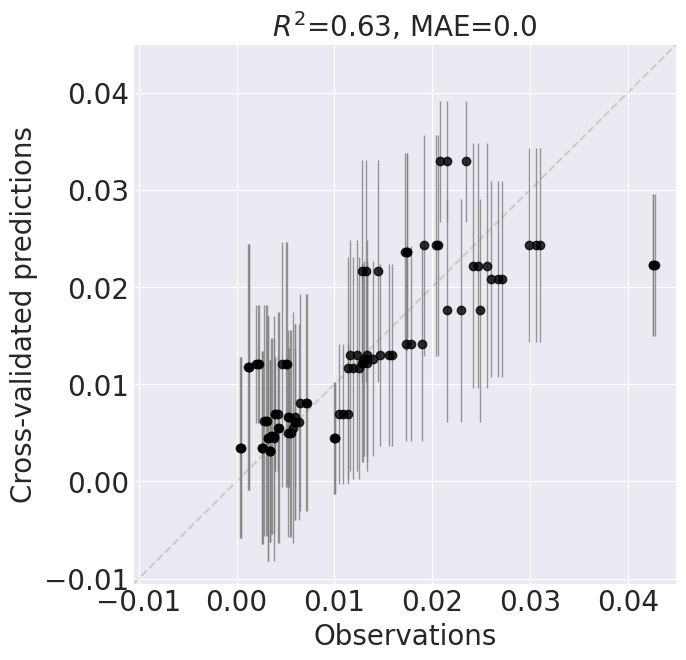

Building models…
Fitting L0 models…
Building TPOT models…


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: GradientBoostingRegressor(input_matrix, alpha=0.75, learning_rate=0.1, loss=huber, max_depth=4, max_features=0.9000000000000001, min_samples_leaf=8, min_samples_split=10, n_estimators=100, subsample=0.6500000000000001)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: LassoLarsCV(RandomForestRegressor(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), bootstrap=False, max_features=0.3, min_samples_leaf=20, min_samples_split=20, n_estimators=100), normalize=True)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: AdaBoostRegressor(AdaBoostRegressor(FeatureAgglomeration(FeatureAgglomeration(input_matrix, affinity=manhattan, linkage=average), affinity=l1, linkage=average), learning_rate=1.0, loss=exponential, n_estimators=100), learning_rate=0.5, loss=square, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


Best pipeline: XGBRegressor(VarianceThreshold(input_matrix, threshold=0.01), learning_rate=0.1, max_depth=5, min_child_weight=6, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.8, verbosity=0)


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Done fitting L0 models in 175.54 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the p

Building ensemble model (4 sampling jobs)…


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, omegas]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 27 seconds.
/usr/local/art/.venv/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Done building ensemble model in 35.89 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.046002,1361.101806,0.043719,4.027562e-03,-40.740680
Random Forest Regressor,0.000457,8.400810,0.000402,3.708337e-07,0.996157
Support Vector Regressor,0.012128,430.395353,0.006441,1.885796e-04,-0.954393
Kernel Ridge Regressor,0.001288,20.862528,0.001324,3.411193e-06,0.964647
K-NN Regressor,0.002954,81.223181,0.002826,1.671318e-05,0.826789
Gaussian Process Regressor,0.000339,3.615911,0.000373,2.539643e-07,0.997368
Gradient Boosting Regressor,0.000330,3.535527,0.000364,2.410027e-07,0.997502
TPOT Regressor 1,0.000703,7.806005,0.001733,3.498269e-06,0.963745
TPOT Regressor 2,0.000352,3.763986,0.000378,2.668717e-07,0.997234


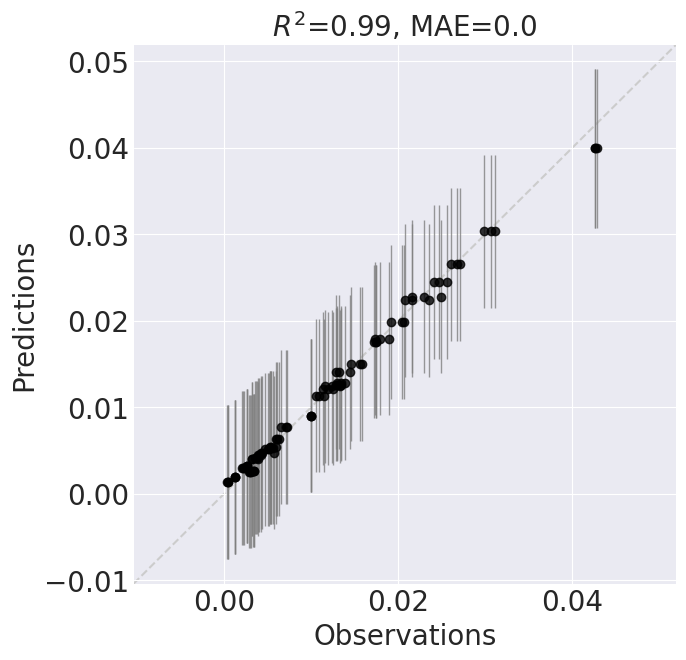

Done building models in 215.26 s


In [41]:

art = train_art(df_stacked, user_params, 'art_DBTL3.cpkl')

# art = RecommendationEngine(df = df_stacked)


In [42]:
# import cloudpickle as cpickle
# with open('../flaviolin data/DBTL6/art.cpkl', "rb") as input_file:
#     art_loaded = cpickle.load(input_file)

### Define the function we will use to generate recommendations

In [43]:
from scipy.optimize import differential_evolution, Bounds
def recommend_DE(art, user_params):
    def obj_func(x, art, draws):
        #print(x.shape)
        foo = art.post_pred_stats(x)
        #file1.write(str(x.flatten()[1:-1]))
        G = np.squeeze((1-art.alpha)*foo[0] +  art.alpha*foo[1])
        draws.append(np.append(x,G))

        return -G

    f = lambda x: obj_func(x,art, draws)
    draws = []
    result = differential_evolution(f, Bounds(art.bounds.values[:,0], art.bounds.values[:,1]), \
                                    maxiter = user_params['maxiter'], popsize= user_params['popsize'], vectorized = False)

    draws = np.array(draws) #make into a numpy array
    draws_padded = np.hstack((draws, np.reshape(draws[:,-1], [-1,1]))) # add an extra column in the end to achieve n_input_vars+2

    from art.core.recommender import Recommender

    recommender = Recommender(
                art.loader,
                art.create_bounds(),
                art._args,
                publish_recs=False,
                # ### Pass-through RE params  #######
                # self.input_vars,
                # self.num_recommendations,
                # self.output_dir,
                # self.rel_rec_distance,
                # self.response_vars,
                # self.testing,
                # self.verbose,
                # self.warning_callback,
            )
    recommendations = recommender.select(draws_padded, user_params['distance_type'])
    return recommendations, draws

In [44]:
art.num_recommendations


16

### Generate exploration recommendations

In [47]:
from scipy.optimize import differential_evolution, Bounds
user_params['maxiter'] = 10
user_params['popsize'] = 500
user_params['distance_type'] = 'at_least_one'
art.alpha = user_params['alpha_explor']
art.num_recommendations = user_params['n_instances_explor']
art.rel_rec_distance = 10
recs_explore, draws_explore = recommend_DE(art, user_params)



Choosing recommendations (71,626 candidates)…


Done choosing recommendations in 211.81 s


In [48]:
recs_explore

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM]
0,0.000400,66.750254,1.920390,6.422140,0.100000,14.059542,0.052000,497.923422,0.000300,0.003000,0.001000,0.008000,0.000010
1,0.003116,66.750641,1.895454,6.438428,0.097366,14.030724,0.199599,497.920272,0.000294,0.002793,0.000695,0.005900,0.000027
2,0.002521,103.935952,1.574595,5.002460,0.096235,13.352076,0.058269,496.724740,0.000280,0.002802,0.000924,0.005394,0.000255
3,0.014431,122.214511,0.216991,2.382060,0.099725,11.781273,0.741833,496.502531,0.000293,0.002968,0.000997,0.004588,0.000611
4,0.013210,156.405637,1.429833,2.551329,0.093805,11.772126,0.526236,498.463992,0.000240,0.002971,0.000964,0.004349,0.000178
5,0.002293,15.585715,2.178632,4.958269,0.023811,7.227938,5.186840,414.098881,0.000043,0.001706,0.000209,0.001252,0.000739
6,0.019815,2.438664,1.559669,1.496754,0.071106,9.646110,4.720353,499.592575,0.000179,0.000158,0.000338,0.005856,0.000919
7,0.011525,163.525376,1.911729,4.397607,0.094752,14.081191,3.334316,494.645336,0.000235,0.002381,0.000976,0.002809,0.000161
8,0.022834,14.400261,2.238060,4.058044,0.066685,7.563319,4.130347,87.907755,0.000185,0.001785,0.000490,0.001011,0.000996
9,0.035365,125.070509,2.658501,2.043345,0.025682,9.077471,4.940375,463.312797,0.000127,0.000656,0.000211,0.001853,0.000990


In [49]:
mean_explore, std_explore = art.post_pred_stats(recs_explore[art._args.input_vars].values)
recs_explore['OD340yield_pred'] = mean_explore 
recs_explore['OD340yield_std'] = std_explore 
recs_explore

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340yield_pred,OD340yield_std
0,0.000400,66.750254,1.920390,6.422140,0.100000,14.059542,0.052000,497.923422,0.000300,0.003000,0.001000,0.008000,0.000010,0.010839,0.005574
1,0.003116,66.750641,1.895454,6.438428,0.097366,14.030724,0.199599,497.920272,0.000294,0.002793,0.000695,0.005900,0.000027,0.010426,0.005346
2,0.002521,103.935952,1.574595,5.002460,0.096235,13.352076,0.058269,496.724740,0.000280,0.002802,0.000924,0.005394,0.000255,0.009363,0.005321
3,0.014431,122.214511,0.216991,2.382060,0.099725,11.781273,0.741833,496.502531,0.000293,0.002968,0.000997,0.004588,0.000611,0.008289,0.005240
4,0.013210,156.405637,1.429833,2.551329,0.093805,11.772126,0.526236,498.463992,0.000240,0.002971,0.000964,0.004349,0.000178,0.008052,0.005218
5,0.002293,15.585715,2.178632,4.958269,0.023811,7.227938,5.186840,414.098881,0.000043,0.001706,0.000209,0.001252,0.000739,0.017742,0.004934
6,0.019815,2.438664,1.559669,1.496754,0.071106,9.646110,4.720353,499.592575,0.000179,0.000158,0.000338,0.005856,0.000919,0.033843,0.004893
7,0.011525,163.525376,1.911729,4.397607,0.094752,14.081191,3.334316,494.645336,0.000235,0.002381,0.000976,0.002809,0.000161,0.007183,0.004864
8,0.022834,14.400261,2.238060,4.058044,0.066685,7.563319,4.130347,87.907755,0.000185,0.001785,0.000490,0.001011,0.000996,0.014635,0.004765
9,0.035365,125.070509,2.658501,2.043345,0.025682,9.077471,4.940375,463.312797,0.000127,0.000656,0.000211,0.001853,0.000990,0.004039,0.004710


### Generate exploitation recommendations

In [56]:
# user_params['maxiter'] = 1000
# user_params['popsize'] = 500
art.alpha = user_params['alpha_exploit']
art.num_recommendations = user_params['n_instances_exploit']
recs_exploit, draws_exploit = recommend_DE(art, user_params)

Choosing recommendations (72,578 candidates)…


Done choosing recommendations in 0.32 s


In [58]:
recs_exploit.head()


,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM]
0,0.001153,3.966669,0.134011,3.823280,0.100000,10.400971,0.328503,419.927502,0.000251,0.003000,0.001000,0.000080,0.000066
1,0.008312,3.115523,0.115745,4.936220,0.094109,10.007719,1.509356,485.655564,0.000168,0.001920,0.000936,0.005219,0.000522
2,0.000647,4.213814,1.678308,4.062872,0.098552,8.959183,0.094732,385.729643,0.000210,0.002937,0.000831,0.003080,0.000515
3,0.017363,4.512512,0.871732,4.282033,0.093247,9.937844,0.186537,471.389608,0.000195,0.002188,0.000957,0.004514,0.000542
4,0.002504,2.943125,1.481084,4.942215,0.093911,8.133338,1.145048,461.821354,0.000256,0.001953,0.001000,0.003047,0.000122


In [60]:
mean_exploit, std_exploit = art.post_pred_stats(recs_exploit[art._args.input_vars].values)
recs_exploit['OD340yield_pred'] = mean_exploit 
recs_exploit['OD340yield_std'] = std_exploit 

In [61]:
recs_explore['Label'] = 'explore'
recs_exploit['Label'] = 'exploit'

In [62]:
recs_explore



,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340yield_pred,OD340yield_std,Label
0,0.000400,66.750254,1.920390,6.422140,0.100000,14.059542,0.052000,497.923422,0.000300,0.003000,0.001000,0.008000,0.000010,0.010839,0.005574,explore
1,0.003116,66.750641,1.895454,6.438428,0.097366,14.030724,0.199599,497.920272,0.000294,0.002793,0.000695,0.005900,0.000027,0.010426,0.005346,explore
2,0.002521,103.935952,1.574595,5.002460,0.096235,13.352076,0.058269,496.724740,0.000280,0.002802,0.000924,0.005394,0.000255,0.009363,0.005321,explore
3,0.014431,122.214511,0.216991,2.382060,0.099725,11.781273,0.741833,496.502531,0.000293,0.002968,0.000997,0.004588,0.000611,0.008289,0.005240,explore
4,0.013210,156.405637,1.429833,2.551329,0.093805,11.772126,0.526236,498.463992,0.000240,0.002971,0.000964,0.004349,0.000178,0.008052,0.005218,explore
5,0.002293,15.585715,2.178632,4.958269,0.023811,7.227938,5.186840,414.098881,0.000043,0.001706,0.000209,0.001252,0.000739,0.017742,0.004934,explore
6,0.019815,2.438664,1.559669,1.496754,0.071106,9.646110,4.720353,499.592575,0.000179,0.000158,0.000338,0.005856,0.000919,0.033843,0.004893,explore
7,0.011525,163.525376,1.911729,4.397607,0.094752,14.081191,3.334316,494.645336,0.000235,0.002381,0.000976,0.002809,0.000161,0.007183,0.004864,explore
8,0.022834,14.400261,2.238060,4.058044,0.066685,7.563319,4.130347,87.907755,0.000185,0.001785,0.000490,0.001011,0.000996,0.014635,0.004765,explore
9,0.035365,125.070509,2.658501,2.043345,0.025682,9.077471,4.940375,463.312797,0.000127,0.000656,0.000211,0.001853,0.000990,0.004039,0.004710,explore


In [63]:
recs_exploit


,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340yield_pred,OD340yield_std,Label
0,0.001153,3.966669,0.134011,3.823280,0.100000,10.400971,0.328503,419.927502,0.000251,0.003000,0.001000,0.000080,0.000066,0.039740,0.004990,exploit
1,0.008312,3.115523,0.115745,4.936220,0.094109,10.007719,1.509356,485.655564,0.000168,0.001920,0.000936,0.005219,0.000522,0.038784,0.004869,exploit
2,0.000647,4.213814,1.678308,4.062872,0.098552,8.959183,0.094732,385.729643,0.000210,0.002937,0.000831,0.003080,0.000515,0.038708,0.004804,exploit
3,0.017363,4.512512,0.871732,4.282033,0.093247,9.937844,0.186537,471.389608,0.000195,0.002188,0.000957,0.004514,0.000542,0.038705,0.004912,exploit
4,0.002504,2.943125,1.481084,4.942215,0.093911,8.133338,1.145048,461.821354,0.000256,0.001953,0.001000,0.003047,0.000122,0.038218,0.004950,exploit


### Concatenate the recommendations

In [64]:
df_target = pd.concat([recs_explore, recs_exploit]).reset_index()
df_target.rename(columns={'OD340': 'OD340yield_pred'}, inplace=True)



In [65]:
df_target.head()


,index,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340yield_pred,OD340yield_std,Label
0,0,0.000400,66.750254,1.920390,6.422140,0.100000,14.059542,0.052000,497.923422,0.000300,0.003000,0.001000,0.008000,0.000010,0.010839,0.005574,explore
1,1,0.003116,66.750641,1.895454,6.438428,0.097366,14.030724,0.199599,497.920272,0.000294,0.002793,0.000695,0.005900,0.000027,0.010426,0.005346,explore
2,2,0.002521,103.935952,1.574595,5.002460,0.096235,13.352076,0.058269,496.724740,0.000280,0.002802,0.000924,0.005394,0.000255,0.009363,0.005321,explore
3,3,0.014431,122.214511,0.216991,2.382060,0.099725,11.781273,0.741833,496.502531,0.000293,0.002968,0.000997,0.004588,0.000611,0.008289,0.005240,explore
4,4,0.013210,156.405637,1.429833,2.551329,0.093805,11.772126,0.526236,498.463992,0.000240,0.002971,0.000964,0.004349,0.000178,0.008052,0.005218,explore


In [66]:
df_target = df_target.drop(columns=['index'])
df_target.head()



,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340yield_pred,OD340yield_std,Label
0,0.000400,66.750254,1.920390,6.422140,0.100000,14.059542,0.052000,497.923422,0.000300,0.003000,0.001000,0.008000,0.000010,0.010839,0.005574,explore
1,0.003116,66.750641,1.895454,6.438428,0.097366,14.030724,0.199599,497.920272,0.000294,0.002793,0.000695,0.005900,0.000027,0.010426,0.005346,explore
2,0.002521,103.935952,1.574595,5.002460,0.096235,13.352076,0.058269,496.724740,0.000280,0.002802,0.000924,0.005394,0.000255,0.009363,0.005321,explore
3,0.014431,122.214511,0.216991,2.382060,0.099725,11.781273,0.741833,496.502531,0.000293,0.002968,0.000997,0.004588,0.000611,0.008289,0.005240,explore
4,0.013210,156.405637,1.429833,2.551329,0.093805,11.772126,0.526236,498.463992,0.000240,0.002971,0.000964,0.004349,0.000178,0.008052,0.005218,explore


In [67]:
user_params['standard_media_file']



'../flaviolin yield data/standard_recipe_concentrations.csv'

In [68]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")

df_stand


,Concentration,Solubility
Component,,
MOPS[mM],40.00000,1700.00
Tricine[mM],4.00000,500.08
H3BO3[mM],0.00400,700.00
Glucose[mM],20.00000,5045.63
K2SO4[mM],0.29000,636.98
K2HPO4[mM],1.32000,8564.84
FeSO4[mM],0.01000,1645.73
NH4Cl[mM],9.52000,6543.28
MgCl2[mM],0.52000,569.27


In [69]:
# df_stand = df_stand.rename(columns = {"Concentration":'Concentration[mM]'} )
# df_stand

In [70]:
ub = 1.1
lb = 0.9
df_control = pd.DataFrame(columns=user_params['components'])

for component in user_params['components']:
    stand_conc = df_stand.loc[component]['Concentration']
    df_control.at['Control', component] = stand_conc*np.random.uniform(lb, ub)

df_control

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM]
Control,0.00404,20.702191,0.284786,1.195734,0.009621,8.606283,0.477038,50.425498,0.00003,0.000278,0.000097,0.000765,0.000105


In [71]:
for component in user_params['components'][:-1]:
     assert(all(df_control.at['Control', component] != control_lines[component]))

In [72]:
control_predicted_mean, control_predicted_std = art.post_pred_stats(
            df_control.values
        )
df_control['OD340yield_pred'] = control_predicted_mean
df_control['OD340yield_std'] = control_predicted_std
df_control['Label'] = 'standard'

In [73]:
df_control

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340yield_pred,OD340yield_std,Label
Control,0.00404,20.702191,0.284786,1.195734,0.009621,8.606283,0.477038,50.425498,0.00003,0.000278,0.000097,0.000765,0.000105,0.012344,0.004526,standard


### Save the training data

In [75]:
df_train = df[user_params['components']]
df_train['OD340'] = df['OD340']
df_train['OD340yield'] = df['OD340_yield']
df_train

/tmp/ipykernel_508/2030356668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['OD340'] = df['OD340']
/tmp/ipykernel_508/2030356668.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['OD340yield'] = df['OD340_yield']


Measurement Type,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340,OD340yield
0,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.1664,0.005044
1,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.1707,0.005174
2,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.1535,0.004653
3,0.001096,129.69516,0.215986,5.430301,0.070543,9.628863,0.396082,21.94981,0.000185,0.000054,0.000027,0.000771,0.000028,0.3910,0.003015
4,0.001096,129.69516,0.215986,5.430301,0.070543,9.628863,0.396082,21.94981,0.000185,0.000054,0.000027,0.000771,0.000028,0.4007,0.00309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.001576,10.077184,0.036933,6.538513,0.008999,7.031522,0.250629,9.100841,0.000005,0.000068,0.0001,0.0008,0.0001,0.1332,0.013218
92,0.001576,10.077184,0.036933,6.538513,0.008999,7.031522,0.250629,9.100841,0.000005,0.000068,0.0001,0.0008,0.0001,0.1453,0.014419
93,0.004091,19.348252,0.30044,1.399625,0.009412,9.987207,0.525179,53.652264,0.00003,0.000276,0.0001,0.0008,0.0001,0.2575,0.013309
94,0.004091,19.348252,0.30044,1.399625,0.009412,9.987207,0.525179,53.652264,0.00003,0.000276,0.0001,0.0008,0.0001,0.2234,0.011546


In [76]:
train_predicted_mean, train_predicted_std = art.post_pred_stats(
            df_train.values[:, :-2]
        )
df_train['OD340yield_pred'] = train_predicted_mean
df_train['OD340yield_std'] = train_predicted_std
df_train['OD340yield_cv_pred'] = art.model_df_cv[0]["Predictions"]["Ensemble Model"]
df_train['OD340yield_cv_std'] = art.model_df_cv[0]["Predictions StDev"]["Ensemble Model"]
df_train['Label'] = 'train'

control_lines = df[df['Line Name'].str.find('_F8') > 0]

df_train.loc[control_lines.index, 'Label'] = 'standard'

/tmp/ipykernel_508/1673626879.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['OD340yield_pred'] = train_predicted_mean
/tmp/ipykernel_508/1673626879.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['OD340yield_std'] = train_predicted_std
/tmp/ipykernel_508/1673626879.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [77]:
df_train

Measurement Type,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340,OD340yield,OD340yield_pred,OD340yield_std,OD340yield_cv_pred,OD340yield_cv_std,Label
0,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.1664,0.005044,0.005135,0.004527,0.012029,0.006412,train
1,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.1707,0.005174,0.005135,0.004527,0.012029,0.006412,train
2,0.003661,32.989243,0.144954,0.61429,0.01745,7.979403,0.270786,26.240883,0.000021,0.000706,0.000188,0.000546,0.000092,0.1535,0.004653,0.005135,0.004527,0.012029,0.006412,train
3,0.001096,129.69516,0.215986,5.430301,0.070543,9.628863,0.396082,21.94981,0.000185,0.000054,0.000027,0.000771,0.000028,0.3910,0.003015,0.002556,0.004528,0.006245,0.006055,train
4,0.001096,129.69516,0.215986,5.430301,0.070543,9.628863,0.396082,21.94981,0.000185,0.000054,0.000027,0.000771,0.000028,0.4007,0.00309,0.002556,0.004528,0.006245,0.006055,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.001576,10.077184,0.036933,6.538513,0.008999,7.031522,0.250629,9.100841,0.000005,0.000068,0.0001,0.0008,0.0001,0.1332,0.013218,0.014064,0.004526,0.021609,0.005823,train
92,0.001576,10.077184,0.036933,6.538513,0.008999,7.031522,0.250629,9.100841,0.000005,0.000068,0.0001,0.0008,0.0001,0.1453,0.014419,0.014064,0.004526,0.021609,0.005823,train
93,0.004091,19.348252,0.30044,1.399625,0.009412,9.987207,0.525179,53.652264,0.00003,0.000276,0.0001,0.0008,0.0001,0.2575,0.013309,0.012423,0.004524,0.012960,0.006057,standard
94,0.004091,19.348252,0.30044,1.399625,0.009412,9.987207,0.525179,53.652264,0.00003,0.000276,0.0001,0.0008,0.0001,0.2234,0.011546,0.012423,0.004524,0.012960,0.006057,standard


### Plot the recommendations

In [80]:

df_target_plot = pd.concat([recs_explore, recs_exploit]).reset_index()
df_target_plot.rename(columns={'OD340yield': 'OD340yield_pred'}, inplace=True)
df_target_plot = pd.concat([df_target_plot,df_control]).reset_index(drop=True)

df_target_plot.head()

,index,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340yield_pred,OD340yield_std,Label
0,0.0,0.0004,66.750254,1.92039,6.42214,0.1,14.059542,0.052,497.923422,0.0003,0.003,0.001,0.008,0.00001,0.010839,0.005574,explore
1,1.0,0.003116,66.750641,1.895454,6.438428,0.097366,14.030724,0.199599,497.920272,0.000294,0.002793,0.000695,0.0059,0.000027,0.010426,0.005346,explore
2,2.0,0.002521,103.935952,1.574595,5.00246,0.096235,13.352076,0.058269,496.72474,0.00028,0.002802,0.000924,0.005394,0.000255,0.009363,0.005321,explore
3,3.0,0.014431,122.214511,0.216991,2.38206,0.099725,11.781273,0.741833,496.502531,0.000293,0.002968,0.000997,0.004588,0.000611,0.008289,0.005240,explore
4,4.0,0.01321,156.405637,1.429833,2.551329,0.093805,11.772126,0.526236,498.463992,0.00024,0.002971,0.000964,0.004349,0.000178,0.008052,0.005218,explore


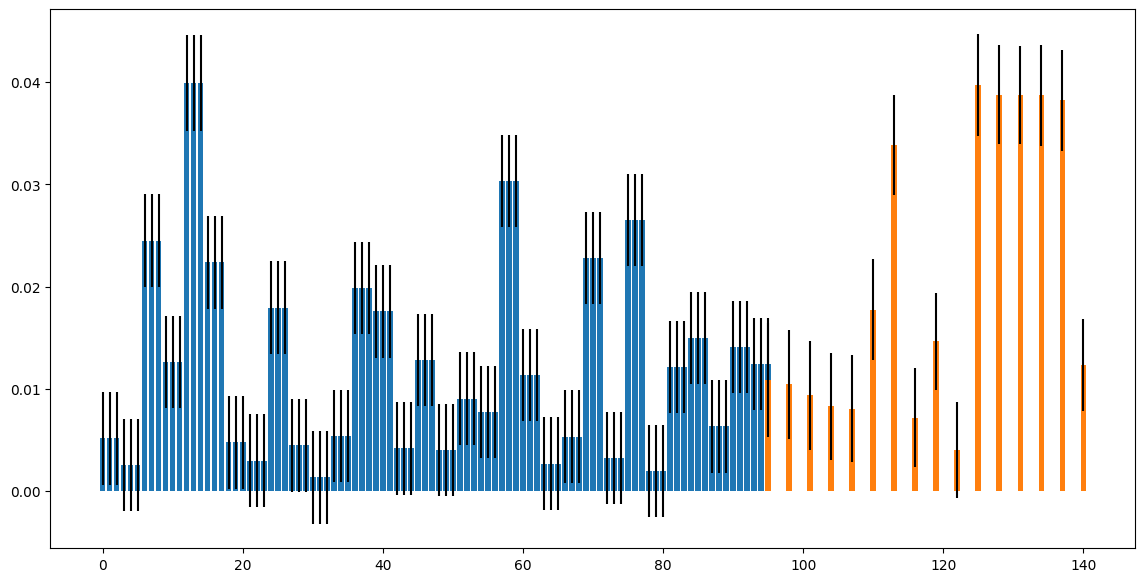

In [81]:
fig, ax = plt.subplots(figsize = (14,7))
ax.bar(df_train.index, df_train['OD340yield_pred'], 
       yerr =df_train['OD340yield_std'] )
ax.bar(df_target_plot.index*3+max(df_train.index), df_target_plot['OD340yield_pred'], 
       yerr = df_target_plot['OD340yield_std'] )
plt.show()

In [82]:
file = f"{user_params['output_dir']}/train_pred.csv"
df_train.to_csv(file)


In [83]:
df_target = pd.concat([df_target,df_control]).reset_index(drop=True)
df_target

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340yield_pred,OD340yield_std,Label
0,0.0004,66.750254,1.92039,6.42214,0.1,14.059542,0.052,497.923422,0.0003,0.003,0.001,0.008,0.00001,0.010839,0.005574,explore
1,0.003116,66.750641,1.895454,6.438428,0.097366,14.030724,0.199599,497.920272,0.000294,0.002793,0.000695,0.0059,0.000027,0.010426,0.005346,explore
2,0.002521,103.935952,1.574595,5.00246,0.096235,13.352076,0.058269,496.72474,0.00028,0.002802,0.000924,0.005394,0.000255,0.009363,0.005321,explore
3,0.014431,122.214511,0.216991,2.38206,0.099725,11.781273,0.741833,496.502531,0.000293,0.002968,0.000997,0.004588,0.000611,0.008289,0.005240,explore
4,0.01321,156.405637,1.429833,2.551329,0.093805,11.772126,0.526236,498.463992,0.00024,0.002971,0.000964,0.004349,0.000178,0.008052,0.005218,explore
5,0.002293,15.585715,2.178632,4.958269,0.023811,7.227938,5.18684,414.098881,0.000043,0.001706,0.000209,0.001252,0.000739,0.017742,0.004934,explore
6,0.019815,2.438664,1.559669,1.496754,0.071106,9.64611,4.720353,499.592575,0.000179,0.000158,0.000338,0.005856,0.000919,0.033843,0.004893,explore
7,0.011525,163.525376,1.911729,4.397607,0.094752,14.081191,3.334316,494.645336,0.000235,0.002381,0.000976,0.002809,0.000161,0.007183,0.004864,explore
8,0.022834,14.400261,2.23806,4.058044,0.066685,7.563319,4.130347,87.907755,0.000185,0.001785,0.00049,0.001011,0.000996,0.014635,0.004765,explore
9,0.035365,125.070509,2.658501,2.043345,0.025682,9.077471,4.940375,463.312797,0.000127,0.000656,0.000211,0.001853,0.00099,0.004039,0.004710,explore


In [84]:
df_target = df_target.loc[df_target.index.repeat(user_params['n_replicates'])]
df_target

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340yield_pred,OD340yield_std,Label
0,0.0004,66.750254,1.92039,6.42214,0.1,14.059542,0.052,497.923422,0.0003,0.003,0.001,0.008,0.00001,0.010839,0.005574,explore
0,0.0004,66.750254,1.92039,6.42214,0.1,14.059542,0.052,497.923422,0.0003,0.003,0.001,0.008,0.00001,0.010839,0.005574,explore
0,0.0004,66.750254,1.92039,6.42214,0.1,14.059542,0.052,497.923422,0.0003,0.003,0.001,0.008,0.00001,0.010839,0.005574,explore
1,0.003116,66.750641,1.895454,6.438428,0.097366,14.030724,0.199599,497.920272,0.000294,0.002793,0.000695,0.0059,0.000027,0.010426,0.005346,explore
1,0.003116,66.750641,1.895454,6.438428,0.097366,14.030724,0.199599,497.920272,0.000294,0.002793,0.000695,0.0059,0.000027,0.010426,0.005346,explore
1,0.003116,66.750641,1.895454,6.438428,0.097366,14.030724,0.199599,497.920272,0.000294,0.002793,0.000695,0.0059,0.000027,0.010426,0.005346,explore
2,0.002521,103.935952,1.574595,5.00246,0.096235,13.352076,0.058269,496.72474,0.00028,0.002802,0.000924,0.005394,0.000255,0.009363,0.005321,explore
2,0.002521,103.935952,1.574595,5.00246,0.096235,13.352076,0.058269,496.72474,0.00028,0.002802,0.000924,0.005394,0.000255,0.009363,0.005321,explore
2,0.002521,103.935952,1.574595,5.00246,0.096235,13.352076,0.058269,496.72474,0.00028,0.002802,0.000924,0.005394,0.000255,0.009363,0.005321,explore
3,0.014431,122.214511,0.216991,2.38206,0.099725,11.781273,0.741833,496.502531,0.000293,0.002968,0.000997,0.004588,0.000611,0.008289,0.005240,explore


In [85]:
well_rows = 'ABCDEF'
well_columns = '12345678'
well_names = [f'{row}{column}'  for column in well_columns for row in well_rows]

df_target['Well'] = well_names
df_target = df_target.set_index(['Well'])
df_target.head()

,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340yield_pred,OD340yield_std,Label
Well,,,,,,,,,,,,,,,,
A1,0.0004,66.750254,1.92039,6.42214,0.1,14.059542,0.052,497.923422,0.0003,0.003,0.001,0.008,0.00001,0.010839,0.005574,explore
B1,0.0004,66.750254,1.92039,6.42214,0.1,14.059542,0.052,497.923422,0.0003,0.003,0.001,0.008,0.00001,0.010839,0.005574,explore
C1,0.0004,66.750254,1.92039,6.42214,0.1,14.059542,0.052,497.923422,0.0003,0.003,0.001,0.008,0.00001,0.010839,0.005574,explore
D1,0.003116,66.750641,1.895454,6.438428,0.097366,14.030724,0.199599,497.920272,0.000294,0.002793,0.000695,0.0059,0.000027,0.010426,0.005346,explore
E1,0.003116,66.750641,1.895454,6.438428,0.097366,14.030724,0.199599,497.920272,0.000294,0.002793,0.000695,0.0059,0.000027,0.010426,0.005346,explore


In [86]:
df_target


,H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340yield_pred,OD340yield_std,Label
Well,,,,,,,,,,,,,,,,
A1,0.0004,66.750254,1.92039,6.42214,0.1,14.059542,0.052,497.923422,0.0003,0.003,0.001,0.008,0.00001,0.010839,0.005574,explore
B1,0.0004,66.750254,1.92039,6.42214,0.1,14.059542,0.052,497.923422,0.0003,0.003,0.001,0.008,0.00001,0.010839,0.005574,explore
C1,0.0004,66.750254,1.92039,6.42214,0.1,14.059542,0.052,497.923422,0.0003,0.003,0.001,0.008,0.00001,0.010839,0.005574,explore
D1,0.003116,66.750641,1.895454,6.438428,0.097366,14.030724,0.199599,497.920272,0.000294,0.002793,0.000695,0.0059,0.000027,0.010426,0.005346,explore
E1,0.003116,66.750641,1.895454,6.438428,0.097366,14.030724,0.199599,497.920272,0.000294,0.002793,0.000695,0.0059,0.000027,0.010426,0.005346,explore
F1,0.003116,66.750641,1.895454,6.438428,0.097366,14.030724,0.199599,497.920272,0.000294,0.002793,0.000695,0.0059,0.000027,0.010426,0.005346,explore
A2,0.002521,103.935952,1.574595,5.00246,0.096235,13.352076,0.058269,496.72474,0.00028,0.002802,0.000924,0.005394,0.000255,0.009363,0.005321,explore
B2,0.002521,103.935952,1.574595,5.00246,0.096235,13.352076,0.058269,496.72474,0.00028,0.002802,0.000924,0.005394,0.000255,0.009363,0.005321,explore
C2,0.002521,103.935952,1.574595,5.00246,0.096235,13.352076,0.058269,496.72474,0.00028,0.002802,0.000924,0.005394,0.000255,0.009363,0.005321,explore


In [87]:
f"{user_params['output_dir']}/target_concentrations.csv"


'../flaviolin yield data/DBTL3/target_concentrations.csv'

In [88]:
file = f"{user_params['output_dir']}/target_concentrations.csv"
df_target.to_csv(file) 